In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tabulate import tabulate
from difflib import SequenceMatcher
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from itertools import chain, combinations
from fpgrowth_py import fpgrowth
import time

from dna import dna
from scov import numpy_image_dict
from helper import *
import zlib
import lzma

In [156]:
input_file1 = r'./input/China_Seq.txt'

In [157]:
input_file2=  r'./input/USA_Seq.txt'

In [158]:
df_sequence = pd.DataFrame(columns=["line no","sequence ratios"])

In [159]:
count_lines=0

In [160]:
df_sequence

Empty DataFrame
Columns: [line no, sequence ratios]
Index: []

In [161]:
current_start_time = time.time()

In [162]:
with open(input_file1) as file1, open(input_file2) as file2:
    for lineno, (sequence1, sequence2) in enumerate(zip(file1, file2), 1):
        sequence = SequenceMatcher(a=sequence1 , b=sequence2) #comparing both the strings
        #print(lineno," - ",sequence.ratio())
        df_sequence.loc[len(df_sequence.index)] = [lineno,sequence.ratio()]
        df_sequence['line no'] = df_sequence['line no'].astype(int)
        count_lines+=1

In [163]:
current_end_time = time.time()

In [164]:
print("Total Time :",current_end_time-current_start_time)

Total Time : 1.9830663204193115


In [165]:
df_sequence_missings = df_sequence[df_sequence['sequence ratios']<1]

In [166]:
length_changed_genome = len(df_sequence_missings)

In [167]:
perc_missing_values = (length_changed_genome/count_lines)*100

In [168]:
print("Percentage of changed Genome Sequence ",round(perc_missing_values,2),"%")

Percentage of changed Genome Sequence  1.31 %


In [169]:
df_sequence_missings

line no  sequence ratios
121      122         0.985915
249      250         0.985915
251      252         0.985915
254      255         0.985915
426      427         0.985915
589      590         0.985915
601      602         0.985915
611      612         0.989474

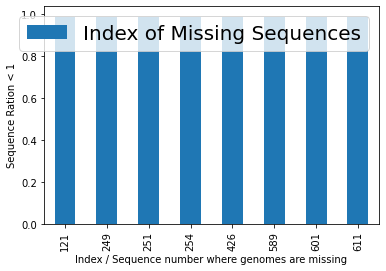

In [170]:
df_sequence_missings['sequence ratios'].plot(kind='bar')

plt.ylabel("Sequence Ration < 1")
plt.xlabel("Index / Sequence number where genomes are missing")

#add custom legend to bar chart
plt.legend(['Index of Missing Sequences'], prop={'size': 20})

In [171]:
sequence1_All=''
sequence2_All=''

In [172]:
with open(input_file1) as file1:
    for lineno in file1:
        lineno=lineno.strip('\n')
        sequence1_All+=lineno

In [173]:
with open(input_file2) as file2:
    for lineno in file2:
        lineno=lineno.strip('\n')
        sequence2_All+=lineno

In [174]:
def basic_Analysis(DNAseq):
    total_base = len(DNAseq)
    num_Adenine = DNAseq.count('A')
    num_Guanine = DNAseq.count('G')
    num_Thymine = DNAseq.count('T')
    num_Cytosine = DNAseq.count('C')
    
    if total_base != num_Adenine + num_Guanine + num_Thymine + num_Cytosine:
        print('Something is not right')
    else : pass
    
    A_percent = num_Adenine / total_base
    G_percent = num_Guanine / total_base
    T_percent = num_Thymine / total_base
    C_percent = num_Cytosine / total_base
    
    #visualization
    x = np.arange(4)
    bases = ['Adenine', 'Guanine', 'Thymine' ,'Cytosine']
    values = [num_Adenine, num_Guanine, num_Thymine, num_Cytosine]
    plt.bar(x,values)
    plt.xticks(x, bases)
    plt.show()
    table = [['total base',total_base,'Percentage',str('100%')],
             ['Adenine:',num_Adenine, 'Percentage:',str(round(A_percent*100,2))+'%'],
            ['Guanine:',num_Guanine, 'Percentage:',str(round(G_percent*100,2))+'%'],
             ['Thynime:',num_Thymine, 'Percentage:',str(round(T_percent*100,2))+'%'],
             ['Cytosine:',num_Cytosine, 'Percentage:',str(round(C_percent*100,2))+'%']]
    print(tabulate(table))
    print('GC content:', round((((num_Guanine + num_Cytosine) / total_base)*100),2),'%')

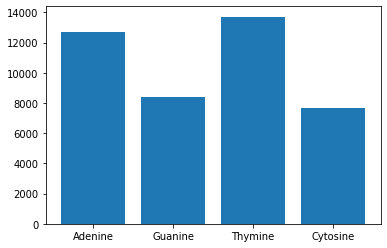

----------  -----  -----------  ------
total base  42483  Percentage   100%
Adenine:    12688  Percentage:  29.87%
Guanine:     8393  Percentage:  19.76%
Thynime:    13709  Percentage:  32.27%
Cytosine:    7693  Percentage:  18.11%
----------  -----  -----------  ------
GC content: 37.86 %


In [175]:
basic_Analysis(sequence1_All)

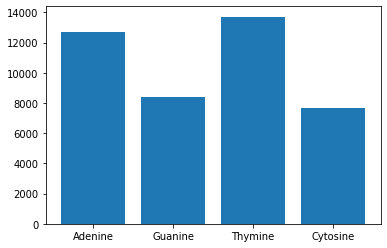

----------  -----  -----------  ------
total base  42483  Percentage   100%
Adenine:    12686  Percentage:  29.86%
Guanine:     8394  Percentage:  19.76%
Thynime:    13713  Percentage:  32.28%
Cytosine:    7690  Percentage:  18.1%
----------  -----  -----------  ------
GC content: 37.86 %


In [176]:
basic_Analysis(sequence2_All)

In [177]:
df_sequence

line no  sequence ratios
0          1         1.000000
1          2         1.000000
2          3         1.000000
3          4         1.000000
4          5         1.000000
..       ...              ...
607      608         1.000000
608      609         1.000000
609      610         1.000000
610      611         1.000000
611      612         0.989474

[612 rows x 2 columns]

In [178]:
def Fapriori(itemSetList, minSup, minConf):
    C1ItemSet = getItemSetFromList(itemSetList)
    # Final result global frequent itemset
    globalFreqItemSet = dict()
    # Storing global itemset with support count
    globalItemSetWithSup = defaultdict(int)

    L1ItemSet = getAboveMinSup(
        C1ItemSet, itemSetList, minSup, globalItemSetWithSup)
    currentLSet = L1ItemSet
    k = 2

    # Calculating frequent item set
    while(currentLSet):
        # Storing frequent itemset
        globalFreqItemSet[k-1] = currentLSet
        # Self-joining Lk
        candidateSet = getUnion(currentLSet, k)
        # Perform subset testing and remove pruned supersets
        candidateSet = pruning(candidateSet, currentLSet, k-1)
        # Scanning itemSet for counting support
        currentLSet = getAboveMinSup(
            candidateSet, itemSetList, minSup, globalItemSetWithSup)
        k += 1

    rules = FassociationRule(globalFreqItemSet, globalItemSetWithSup, minConf)
    rules.sort(key=lambda x: x[2])
    return globalFreqItemSet, rules

In [179]:
def FaprioriFromFile(fname, minSup, minConf):
    C1ItemSet, itemSetList = getFromFile(fname)

    # Final result global frequent itemset
    globalFreqItemSet = dict()
    # Storing global itemset with support count
    globalItemSetWithSup = defaultdict(int)

    L1ItemSet = getAboveMinSup(
        C1ItemSet, itemSetList, minSup, globalItemSetWithSup)
    currentLSet = L1ItemSet
    k = 2

    # Calculating frequent item set
    while(currentLSet):
        # Storing frequent itemset
        globalFreqItemSet[k-1] = currentLSet
        # Self-joining Lk
        candidateSet = getUnion(currentLSet, k)
        # Perform subset testing and remove pruned supersets
        candidateSet = pruning(candidateSet, currentLSet, k-1)
        # Scanning itemSet for counting support
        currentLSet = getAboveMinSup(
            candidateSet, itemSetList, minSup, globalItemSetWithSup)
        k += 1

    rules = associationRule(globalFreqItemSet, globalItemSetWithSup, minConf)
    rules.sort(key=lambda x: x[2])

    return globalFreqItemSet, rules

In [180]:
def powerset(s):
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

In [181]:
def getFromFile(fname):
    itemSets = []
    itemSet = set()

    with open(fname, 'r') as file:
        csv_reader = reader(file)
        for line in csv_reader:
            line = list(filter(None, line))
            record = set(line)
            for item in record:
                itemSet.add(frozenset([item]))
            itemSets.append(record)
    return itemSet, itemSets

In [182]:
def getAboveMinSup(itemSet, itemSetList, minSup, globalItemSetWithSup):
    freqItemSet = set()
    localItemSetWithSup = defaultdict(int)

    for item in itemSet:
        for itemSet in itemSetList:
            if item.issubset(itemSet):
                globalItemSetWithSup[item] += 1
                localItemSetWithSup[item] += 1

    for item, supCount in localItemSetWithSup.items():
        support = float(supCount / len(itemSetList))
        if(support >= minSup):
            freqItemSet.add(item)

    return freqItemSet

In [183]:
def getUnion(itemSet, length):
    return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])

In [184]:
def pruning(candidateSet, prevFreqSet, length):
    tempCandidateSet = candidateSet.copy()
    for item in candidateSet:
        subsets = combinations(item, length)
        for subset in subsets:
            # if the subset is not in previous K-frequent get, then remove the set
            if(frozenset(subset) not in prevFreqSet):
                tempCandidateSet.remove(item)
                break
    return tempCandidateSet

In [185]:
def FassociationRule(freqItemSet, itemSetWithSup, minConf):
    rules = []
    for k, itemSet in freqItemSet.items():
        for item in itemSet:
            subsets = powerset(item)
            for s in subsets:
                confidence = float(
                    itemSetWithSup[item] / itemSetWithSup[frozenset(s)])
                if(confidence > minConf):
                    rules.append([set(s), set(item.difference(s)), confidence])
    return rules

In [186]:
def getItemSetFromList(itemSetList):
    tempItemSet = set()

    for itemSet in itemSetList:
        for item in itemSet:
            tempItemSet.add(frozenset([item]))

    return tempItemSet

In [187]:
g_sequence1=list()
g_sequence2=list()

In [188]:
count=1

In [189]:
with open(input_file1) as file1:
    for lineno in file1:
        if count==3 or count==70 or count ==94 or count==115 or count==130 or count==139 or count==328 or count==415:
            lineno = list(lineno)
            lineno.remove("\n")
            g_sequence1.append(lineno)
            count+=1
        else:
            count+=1

In [190]:
count1=1

In [191]:
with open(input_file2) as file2:
    for lineno in file2:
        if count1==3 or count1==70 or count1 ==94 or count1==115 or count1==130 or count1==139 or count1==328 or count1==415:
            lineno = list(lineno)
            lineno.remove("\n")
            g_sequence2.append(lineno)
            count1+=1
        else:
            count1+=1

In [192]:
freqItemSet, rules = Fapriori(g_sequence1, minSup=.5, minConf=.5)

In [193]:
freqItemSet1, rules1 = Fapriori(g_sequence2, minSup=.5, minConf=.5)

In [194]:
#print(freqItemSet,rules)

In [195]:
#print(freqItemSet1,rules1)

In [196]:
#len(freqItemSet1)

In [197]:
#freqItemSet, rules = fpgrowth(g_sequence1,minSupRatio=0.5,minConf=0.5)
#print(rules) 

In [198]:
corona=''

In [199]:
with open(input_file1) as file1:
    for lineno in file1:
        corona+=lineno

In [200]:
for a in " \n0123456789":
    corona = corona.replace(a, "")

In [201]:
len(corona)

42483

In [202]:
len(zlib.compress(corona.encode("utf-8")))

9579

In [203]:
lzc = lzma.compress(corona.encode("utf-8"))
len(lzc)

8292

In [204]:
# Asn or Asp / B	AAU, AAC; GAU, GAC
# Gln or Glu / Z	CAA, CAG; GAA, GAG
# START	AUG
## Seperating them from the table because these duplicates was creating problems
codons = """
Ala / A	GCU, GCC, GCA, GCG
Ile / I	AUU, AUC, AUA
Arg / R	CGU, CGC, CGA, CGG; AGA, AGG, AGR;
Leu / L	CUU, CUC, CUA, CUG; UUA, UUG, UUR;
Asn / N	AAU, AAC
Lys / K	AAA, AAG
Asp / D	GAU, GAC
Met / M	AUG
Phe / F	UUU, UUC
Cys / C	UGU, UGC
Pro / P	CCU, CCC, CCA, CCG
Gln / Q	CAA, CAG
Ser / S	UCU, UCC, UCA, UCG; AGU, AGC;
Glu / E	GAA, GAG
Thr / T	ACU, ACC, ACA, ACG
Trp / W	UGG
Gly / G	GGU, GGC, GGA, GGG
Tyr / Y	UAU, UAC
His / H	CAU, CAC
Val / V	GUU, GUC, GUA, GUG
STOP	UAA, UGA, UAG""".strip()

for t in codons.split('\n'):
    print(t.split('\t'))

['Ala / A', 'GCU, GCC, GCA, GCG']
['Ile / I', 'AUU, AUC, AUA']
['Arg / R', 'CGU, CGC, CGA, CGG; AGA, AGG, AGR;']
['Leu / L', 'CUU, CUC, CUA, CUG; UUA, UUG, UUR;']
['Asn / N', 'AAU, AAC']
['Lys / K', 'AAA, AAG']
['Asp / D', 'GAU, GAC']
['Met / M', 'AUG']
['Phe / F', 'UUU, UUC']
['Cys / C', 'UGU, UGC']
['Pro / P', 'CCU, CCC, CCA, CCG']
['Gln / Q', 'CAA, CAG']
['Ser / S', 'UCU, UCC, UCA, UCG; AGU, AGC;']
['Glu / E', 'GAA, GAG']
['Thr / T', 'ACU, ACC, ACA, ACG']
['Trp / W', 'UGG']
['Gly / G', 'GGU, GGC, GGA, GGG']
['Tyr / Y', 'UAU, UAC']
['His / H', 'CAU, CAC']
['Val / V', 'GUU, GUC, GUA, GUG']
['STOP', 'UAA, UGA, UAG']


In [205]:
##decoder dictionary
dec = {}  

for t in codons.split('\n'):
    k, v = t.split('\t')
    if '/' in k:
        k = k.split('/')[-1].strip()
    k = k.replace("STOP", "*")
    v = v.replace(",", "").replace(";", "").lower().replace("u", "t").split(" ")
    for vv in v:
        if vv in dec:
            print("duplicate", vv)
        dec[vv] = k
dec

{'gct': 'A',
 'gcc': 'A',
 'gca': 'A',
 'gcg': 'A',
 'att': 'I',
 'atc': 'I',
 'ata': 'I',
 'cgt': 'R',
 'cgc': 'R',
 'cga': 'R',
 'cgg': 'R',
 'aga': 'R',
 'agg': 'R',
 'agr': 'R',
 'ctt': 'L',
 'ctc': 'L',
 'cta': 'L',
 'ctg': 'L',
 'tta': 'L',
 'ttg': 'L',
 'ttr': 'L',
 'aat': 'N',
 'aac': 'N',
 'aaa': 'K',
 'aag': 'K',
 'gat': 'D',
 'gac': 'D',
 'atg': 'M',
 'ttt': 'F',
 'ttc': 'F',
 'tgt': 'C',
 'tgc': 'C',
 'cct': 'P',
 'ccc': 'P',
 'cca': 'P',
 'ccg': 'P',
 'caa': 'Q',
 'cag': 'Q',
 'tct': 'S',
 'tcc': 'S',
 'tca': 'S',
 'tcg': 'S',
 'agt': 'S',
 'agc': 'S',
 'gaa': 'E',
 'gag': 'E',
 'act': 'T',
 'acc': 'T',
 'aca': 'T',
 'acg': 'T',
 'tgg': 'W',
 'ggt': 'G',
 'ggc': 'G',
 'gga': 'G',
 'ggg': 'G',
 'tat': 'Y',
 'tac': 'Y',
 'cat': 'H',
 'cac': 'H',
 'gtt': 'V',
 'gtc': 'V',
 'gta': 'V',
 'gtg': 'V',
 'taa': '*',
 'tga': '*',
 'tag': '*'}

In [206]:
len(set(dec.values())) 

21

In [207]:
genome_sequence1=''
genome_sequence2=''

In [208]:
dict_seq_1 = read_dna_seq('./input/China_Seq_2019_Dec.txt')

In [209]:
# Modify the sequence with dummy 'N' nucleotide.
dict_seq_1 = gene_mod(dict_seq_1)

In [210]:
# Read the dna sequence file-2 previously downloaded from NCBI.
dict_seq_2 = read_dna_seq('./input/USA_Seq_2020_Jan.txt')

In [211]:
# Modify the sequence with dummy 'N' nucleotide.
dict_seq_2 = gene_mod(dict_seq_2)

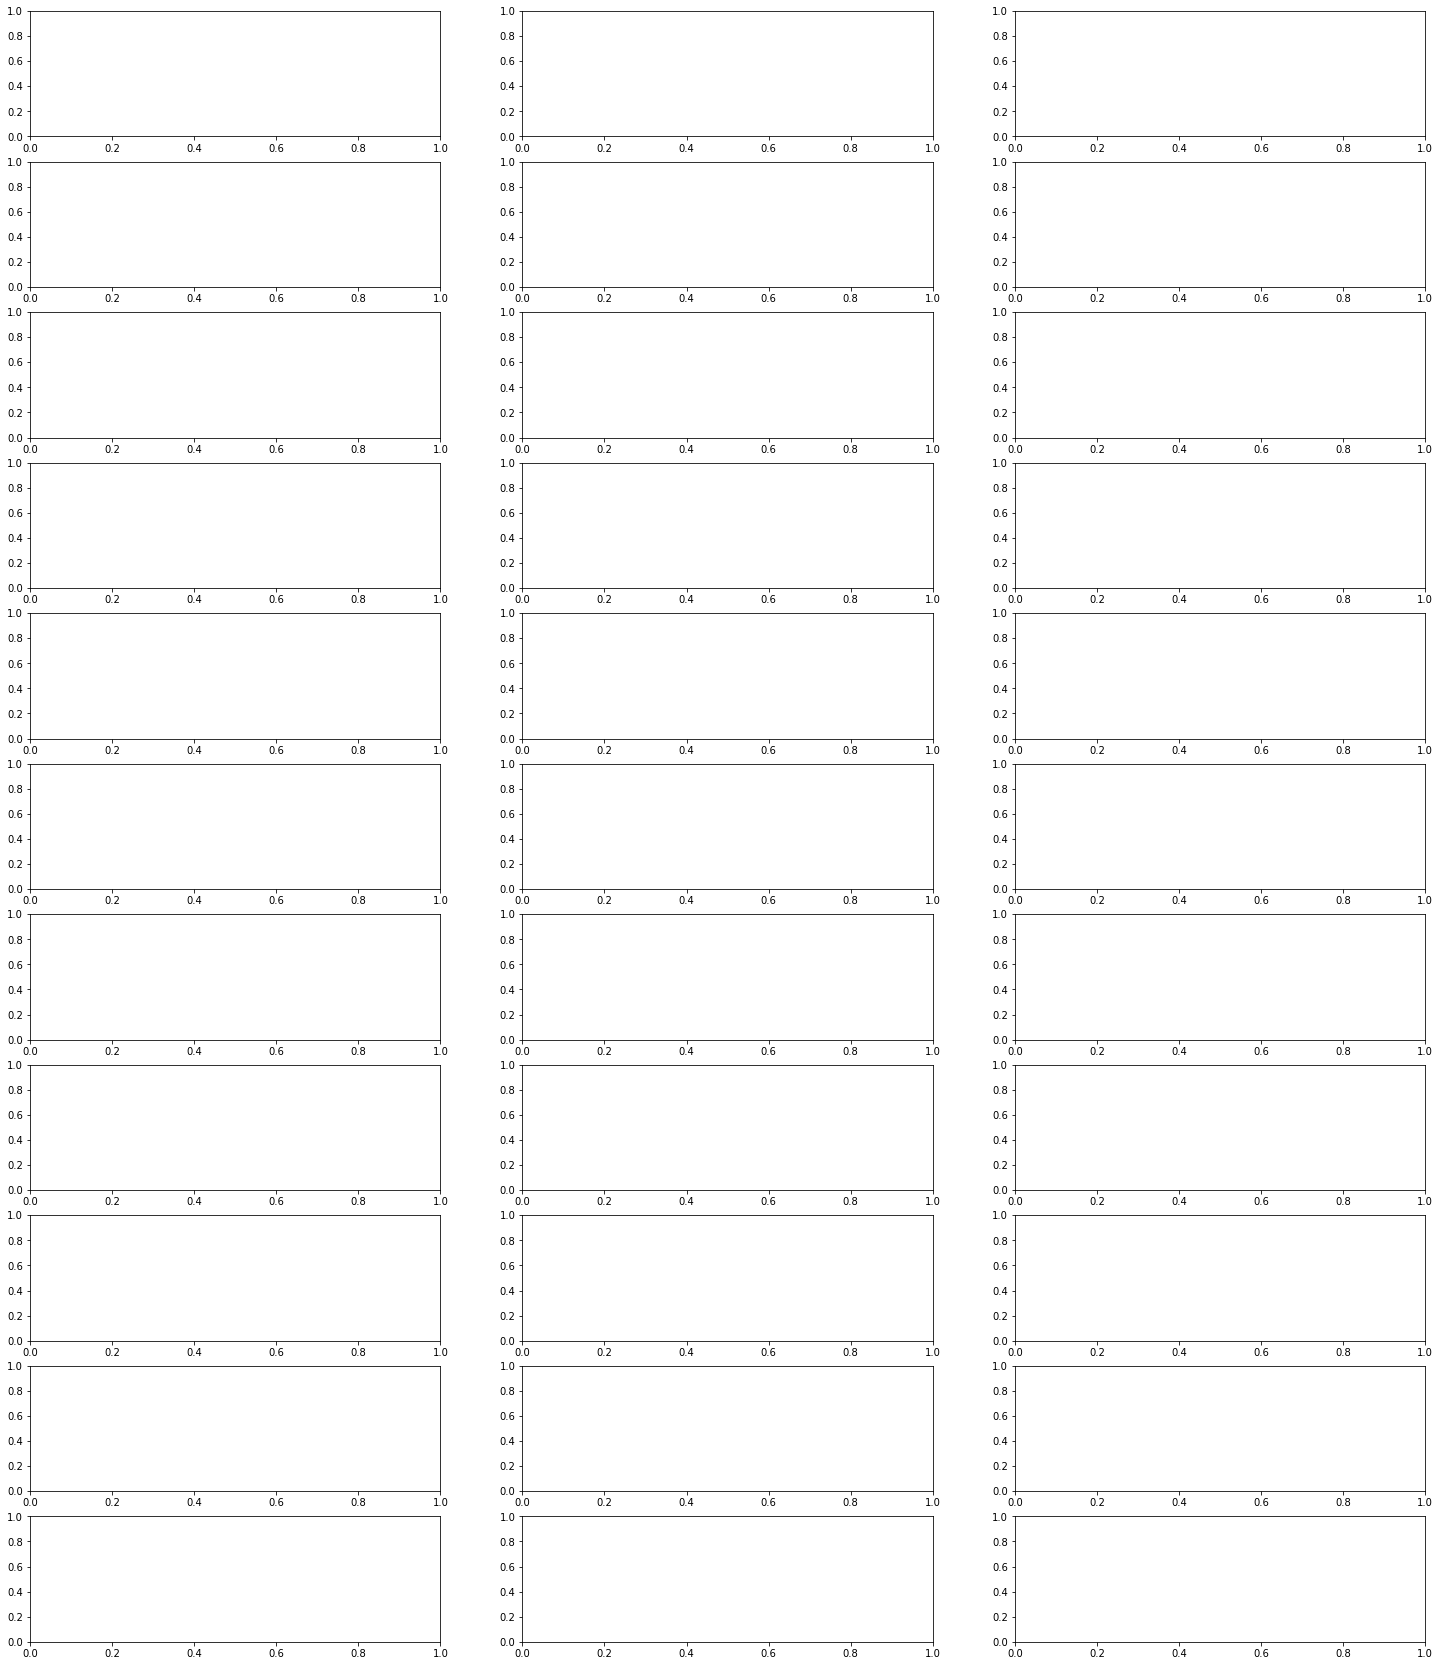

In [212]:
# Create matplotlib subplots for each gene. 
f,ax = plt.subplots(nrows=11,ncols=3,figsize=(25,30))

In [213]:
gene_name = list(numpy_image_dict.keys())

In [214]:
row = 0
col = 0
mut_dict={}

In [215]:
for i in gene_name:
    G = i[5:]
    # Loop thru each gene in the Cornona Virus nucleotide sequence.
    gene_us = dna(dict_seq_1['gene='+G][1])
    # Invoke the transcription method of the class dna 
    gene_us.transcription()
    # Invoke the mothod that converts the gene sequence into a numpy array.
    numpfy_usa = gene_us.numpfy()
    # Reshape the numpy array with a predeifned shape from the numpy_image_dict dictionary.
    numpfy_usa = numpfy_usa.reshape(numpy_image_dict['gene='+G][0])
    # sub-plot the numpy array with matplotlib pcolor method.
    ax[row][col].pcolor(numpfy_usa)
    ax[row][col].set_title(G+' Gene - USA')
    col+=1
    gene_china = dna(dict_seq_2['gene='+G][1])
    # Invoke the transcription method of the class dna 
    gene_china.transcription()
    # Invoke the mothod that converts the gene sequence into a numpy array.
    numpfy_china = gene_china.numpfy()
    # Reshape the numpy array with a predeifned shape from the numpy_image_dict dictionary.
    numpfy_china = numpfy_china.reshape(numpy_image_dict['gene='+G][0])
    # sub-plot the numpy array with matplotlib pcolor method.
    ax[row][col].pcolor(numpfy_china)
    ax[row][col].set_title(G+' Gene - CHINA')
    col+=1

    # To find the gene mutation subtract the numpy array from base sequence with the newer sequence. Here the 
    # the Chinese sequence is the base sequence and the USA sequence is a newer sequence.
    mut = numpfy_china - numpfy_usa
    if mut.any():
        # Here we are looking for a non zero value in the mutated numpy array (result of the subtracting the 2 numpy arrays).
        # Presence of non-zero value means that there is difference between the 2 numpy arrays and the gene has 
        # mutataions. If there are mutations in the gene create a python dictionary "mut_dict" with details as below.
        # {'<Gene_Name-1>': [[<value_of_base_seq>, <value_of_newer_seq>, <value_in_mutated_numpy>, (x_value,y_value)]], '<Gene_Name-2>': [[<value_of_base_seq>, <value_of_newer_seq>, <value_in_mutated_numpy>, (x_value,y_value)]]}
        mut_nec = np.nonzero(mut)
        x=mut_nec[0]
        y=mut_nec[1]
        l=0
        mut_dict[G]=[]
        for i in x:
            us_base = numpfy_usa[i][y[l]]
            ch_base = numpfy_china[i][y[l]]
            mut_base = mut[i][y[l]]
            info_list = [ch_base,us_base,mut_base,(i,y[l])]
            mut_dict[G].append(info_list)
            print("Mutated DNA Base {} in China and Base {} in USA at position {} For the Gene {}".format(ch_base,us_base,(i,y[l]),G))
            l+= 1
    # Giving a title to the matplotlib subplot
    ax[row][col].pcolor(mut)
    ax[row][col].set_title(G+' Gene - Mutataion')
    row+= 1
    col=0

Mutated DNA Base 255 in China and Base 100 in USA at position (74, 6) For the Gene ORF1ab
Mutated DNA Base 100 in China and Base 255 in USA at position (12, 10) For the Gene ORF8
Mutated DNA Base 255 in China and Base 0 in USA at position (17, 24) For the Gene N


In [216]:
f.tight_layout()
# Saving the matplotlib subplot as a jpg.
f.savefig('./output/Gene_Mutation_Analysis.jpg')